 Loading datasets...


C:\Users\SOMESH\AppData\Local\Temp\ipykernel_9076\2254587728.py:14: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv("train.csv", parse_dates=["Date"])


Data Loaded Successfully!
Train shape: (1017209, 9)
Test shape: (41088, 8)
Store shape: (1115, 10)
After merge shape: (1017209, 18)
Cleaning and preparing data...
 Creating features...
Training Random Forest Model...
✅ Model Trained! Validation RMSE: 1197.39


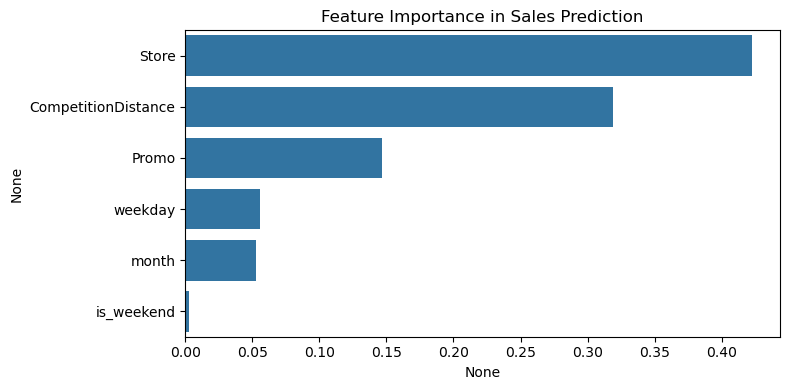

 Model saved: models/rf_model.pkl
Generating predictions on test set...
Predictions saved to: outputs/predicted_sales.csv

 PROJECT COMPLETED SUCCESSFULLY 


In [4]:
# Step 1: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import joblib
import os

# Step 2: Load data
print(" Loading datasets...")
train = pd.read_csv("train.csv", parse_dates=["Date"])
test = pd.read_csv("test.csv", parse_dates=["Date"])
store = pd.read_csv("store.csv")

print("Data Loaded Successfully!")
print("Train shape:", train.shape)
print("Test shape:", test.shape)
print("Store shape:", store.shape)

# Step 3: Merge store information
df = train.merge(store, on="Store", how="left")
print("After merge shape:", df.shape)

# Step 4: Clean data
print("Cleaning and preparing data...")
df = df[df["Open"] == 1]  # remove closed stores
df["CompetitionDistance"] = df["CompetitionDistance"].fillna(1e6)
df["StateHoliday"] = df["StateHoliday"].astype(str)

# Step 5: Feature Engineering
print(" Creating features...")
df["year"] = df["Date"].dt.year
df["month"] = df["Date"].dt.month
df["day"] = df["Date"].dt.day
df["weekday"] = df["Date"].dt.weekday
df["is_weekend"] = df["weekday"].isin([5,6]).astype(int)

# Step 6: Select features & target
features = ["Store", "Promo", "month", "weekday", "CompetitionDistance", "is_weekend"]
target = "Sales"
X = df[features].fillna(0)
y = df[target]

# Step 7: Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 8: Train model
print("Training Random Forest Model...")
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

# Step 9: Evaluate model
y_pred = model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"✅ Model Trained! Validation RMSE: {rmse:.2f}")

# Step 10: Feature Importance
plt.figure(figsize=(8,4))
imp = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)
sns.barplot(x=imp, y=imp.index)
plt.title("Feature Importance in Sales Prediction")
plt.tight_layout()
plt.show()

# Step 11: Save trained model
os.makedirs("models", exist_ok=True)
joblib.dump(model, "models/rf_model.pkl")
print(" Model saved: models/rf_model.pkl")

# Step 12: Predict on Test Data
print("Generating predictions on test set...")
test = test.merge(store, on="Store", how="left")
test["CompetitionDistance"] = test["CompetitionDistance"].fillna(1e6)
test["StateHoliday"] = test["StateHoliday"].astype(str)
test["month"] = test["Date"].dt.month
test["weekday"] = test["Date"].dt.weekday
test["is_weekend"] = test["weekday"].isin([5,6]).astype(int)

X_test = test[features].fillna(0)
test["PredictedSales"] = model.predict(X_test)

# Step 13: Save output
os.makedirs("outputs", exist_ok=True)
test[["Store","Date","PredictedSales"]].to_csv("outputs/predicted_sales.csv", index=False)
print("Predictions saved to: outputs/predicted_sales.csv")

print("\n PROJECT COMPLETED SUCCESSFULLY ")
